pmgus_vbeta.ipynb

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from datetime import datetime, timedelta
#
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
from tqdm import tqdm  # Visualize loop progress
from sklearn.linear_model import LinearRegression
from tenacity import retry, stop_after_attempt, wait_fixed
import openpyxl
import os
import requests
import yfinance as yf

#
from dotenv import load_dotenv

data import (manual) TradingView

In [2]:
# base file path and file path setup
base_dir_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/' 
tv_prefix = 'tv_screen_gap-up_'
file_type_csv = '.csv'
#####---------------------#####
# screen_date = '2024-12-17'
screen_date = '2024-12-18'

#####---------------------#####
tv_filename = base_dir_path + tv_prefix + screen_date + file_type_csv

# READ
trading_view_df = pd.read_csv(tv_filename)

# PRINT
print(tv_filename)
print(len(trading_view_df))
# print first 5 ticker Symbols only
print(trading_view_df['Symbol'].head(5))

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/tv_screen_gap-up_2024-12-18.csv
1820
0     NVDA
1     AMZN
2     META
3    BRK.B
4      TSM
Name: Symbol, dtype: object


setup market cap category groups, criteria configurations, and conditional filtering.

In [3]:
# CREATE CATEGORIES FOR MARKET CAP
def categorize_market_cap(df):
    # categorize stocks groups by market cap
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    conditions = [
        (df['Market capitalization'] >= 200_000_000_000),  # Titans
        (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
        (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
        (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
        (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
        (df['Market capitalization'] <= 50_000_000)  # Shrimp
    ]
    # marekt cap categories list
    categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    return df
# execute categorization
category_setup_df = categorize_market_cap(trading_view_df).copy()
# drop Undefined marketCapType
category_setup_df = category_setup_df[category_setup_df['marketCapType'] != 'Undefined']

# convert necessary columns to numeric
def convert_columns_to_numeric(df, columns):
    """Convert specified columns to numeric types."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# list of columns to convert
numeric_columns = [
    'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
    'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
    'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
    'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
]

# apply conversion
category_setup_df = convert_columns_to_numeric(category_setup_df, numeric_columns)

# CRITERIA CONFIGURATION FOR EACH MARKET CAP CATEGORY
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.03,
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Midlers": { 
        "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

# FILTER STOCKS BASED ON CONFIGURATION CRITERIA - STAGING
def filter_stocks(df, config):
    # stock filtering conditions >=< based on criteria
    conditions = (
        (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
        (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
        (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
        (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
        (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
        (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
        (df['Volatility 1 day'] >= df['Volatility 1 week']) &
        (df['Volatility 1 day'] >= df['Volatility 1 month']) &
        (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
    )
    return df[conditions]

# SCREEN STOCKS BY CATEGORY
def screen_stocks_by_category(df, category):
    """Filter stocks in a category using predefined criteria."""
    config = criteria_config.get(category, {})
    filtered_df = filter_stocks(df, config)
    return filtered_df

# EXECUTE KEY SCREENING FUNCTION AND CREATE DATAFRAME
smash_df = pd.DataFrame()
categories = category_setup_df['marketCapType'].unique()

for category in categories:
    category_df = category_setup_df[category_setup_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    smash_df = pd.concat([smash_df, gap_up_stage_df], ignore_index=True)

# rendered column list and ordering
cols_list = [
    'Symbol', 
    'Description', 
    'marketCapType', 
    'Pre-market Change %', 
    'Pre-market Gap %', 
    'marketCapType',
    'Market capitalization',
    'Price', 
    'Pre-market Open', 
    'Industry', 
    'Index', 
    'Sector', 
    'Exchange',
    'Recent earnings date', 
    'Upcoming earnings date', 
    'Float shares outstanding', 
    'Average Volume 10 days',
    'Average Volume 30 days', 
    'Average Volume 90 days',
    'Relative Volume 1 day', 
    'Relative Volume 5 minutes', 
    'Relative Volume 30 minutes', 
    'Relative Volume at Time', 
    'Analyst Rating',
    'Technical Rating 5 minutes'
]

# filter columns to only include those present in the DataFrame
existing_cols = [col for col in cols_list if col in smash_df.columns]
smash_df = smash_df[existing_cols]

# sort and reset index
smash_df = smash_df.sort_values(
    by=['Pre-market Change %', 'Price'],
    ascending=[False, False]).reset_index(drop=True)

print(f"{smash_df.shape[0]} stocks found.")

54 stocks found.


quick and dirty static screen

TODO****
think abdout adding float???

In [4]:
# quick and dirty filter for high-probability morning momentum trades (Re: Pre-market Gap Up)
def quick_dirty_filter(df):
    return df[
        # strong pre-market movement but not overextended
        (
            (df['Pre-market Change %'] > 3.0) |
            ((df['Pre-market Change %'] > 1.5) & (df['Relative Volume 5 minutes'] > 5.0))
        ) &
        # volume validation
        (df['Relative Volume 5 minutes'] > 2.0) &
        # industry/sector grouping
        (df.groupby('Industry')['Pre-market Change %'].transform('count') > 1)
            ].sort_values('Pre-market Change %', ascending=False)

In [20]:
# EXECUTE quick and dirty filter && CREATE a df and list
smash_qd_df = quick_dirty_filter(smash_df)
smash_qd_list = smash_qd_df['Symbol'].to_list()

# PRINT
print(f'{len(smash_qd_df)} stocks returned from the quick and dirty filter.')
# print(smash_qd_df.columns)
print(smash_qd_list)
# display(smash_qd_df)
display(smash_qd_df.head(2))

10 stocks returned from the quick and dirty filter.
['ARQQ', 'OKLO', 'JBL', 'SDRL', 'WK', 'LTH', 'RIG', 'GLNG', 'STEP', 'CRS']


,Symbol,Description,marketCapType,Pre-market Change %,Pre-market Gap %,marketCapType,Market capitalization,Price,Pre-market Open,Industry,Index,Sector,Exchange,Recent earnings date,Upcoming earnings date,Float shares outstanding,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Relative Volume 1 day,Relative Volume 5 minutes,Relative Volume 30 minutes,Relative Volume at Time,Analyst Rating,Technical Rating 5 minutes
1,ARQQ,Arqit Quantum Inc.,Small caps,14.787879,1.333333,Small caps,4.126323e+08,33.0,33.44,Packaged software,"NASDAQ Composite, NASDAQ Computer",Technology services,NASDAQ,2024-12-05,2025-05-08,4.726850e+06,1210359.1,8.370858e+05,3.468775e+05,2.412323,3.170717,1.475686,2.403656,Strong buy,Strong buy
2,OKLO,Oklo Inc.,Mid caps,12.984293,0.418848,Mid caps,2.332039e+09,19.1,19.18,Industrial machinery,NaN,Producer manufacturing,NYSE,2024-11-14,2025-02-26,7.226545e+07,8344330.0,1.442053e+07,1.206641e+07,0.877310,3.338028,3.189939,0.826468,Buy,Buy


save stock(s) results (output) to .csv

In [ ]:
# string object for quick and dirty results .csv
smash_qd_results_filename = (f"{base_dir_path}smash_quick_dirty_results_{screen_date}{file_type_csv}")
print(smash_qd_results_filename)

# SAVE TO CSV
smash_qd_df.to_csv(smash_qd_results_filename, index=False)

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/smash_quick_dirty_results_2024-12-18.csv


In [10]:
print(len(smash_qd_list))
print(len(smash_qd_df))
print(smash_qd_list)

10
10
['ARQQ', 'OKLO', 'JBL', 'SDRL', 'WK', 'LTH', 'RIG', 'GLNG', 'STEP', 'CRS']


plot #1; SINGLE stock intraday price action.

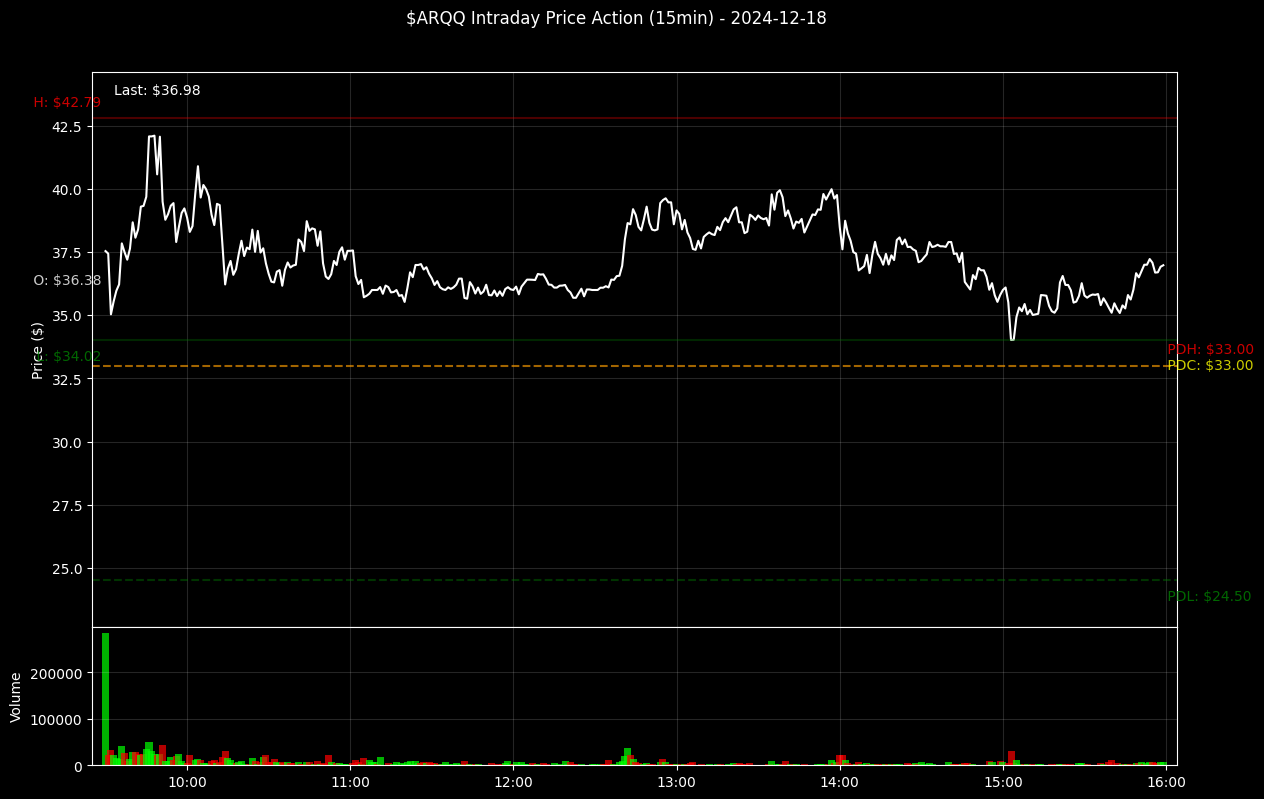

{'prev_day_high': 33.0,
 'prev_day_low': 24.5,
 'prev_day_close': 33.0,
 'today_open': 36.38349914550781,
 'today_high': 42.790000915527344,
 'today_low': 34.02000045776367,
 'today_close': 36.97999954223633}

In [18]:
# intraday price action plot for scaled price levels
def plot_daily_price_levels(symbol, target_date):
    target_date = pd.to_datetime(target_date)
    ####
    prev_day = target_date - pd.DateOffset(days=1)
    ####
    
    # Get previous day's data for levels
    ticker = yf.Ticker(symbol)
    prev_data = ticker.history(start=prev_day, end=target_date, interval='1d')
    
    # Get target day's data with 15-min intervals
    today_data = ticker.history(start=target_date, end=target_date + pd.DateOffset(days=1), interval='1m')
    
    if today_data.empty:
        print(f"No data available for {symbol} on {target_date.date()}")
        return
    
    # Timezone handling
    if today_data.index.tz is not None:
        today_data.index = today_data.index.tz_convert('US/Eastern')
    else:
        today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
    
    # Filter for market hours only (9:30 AM - 4:00 PM ET)
    today_data = today_data.between_time('9:30', '16:00')
    
    # Create plot
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Plot price action
    ax1.plot(today_data.index, today_data['Close'], 
             color='white', linewidth=1.5, label='Price')
    
    # Calculate current day levels
    today_open = today_data['Open'].iloc[0]
    today_high = today_data['High'].max()
    today_low = today_data['Low'].min()
    today_close = today_data['Close'].iloc[-1]
    
    # Calculate all price levels for scaling
    all_price_levels = []
    if not prev_data.empty:
        prev_day_high = prev_data['High'].iloc[-1]
        prev_day_low = prev_data['Low'].iloc[-1]
        prev_day_close = prev_data['Close'].iloc[-1]
        
        all_price_levels.extend([
            prev_day_high, prev_day_low, prev_day_close,
            today_high, today_low, today_open, today_close
        ])
        
        # Calculate proper y-axis limits
        min_price = min(all_price_levels)
        max_price = max(all_price_levels)
        price_range = max_price - min_price
        
        # Add padding (10% of the total range)
        padding = price_range * 0.1
        y_min = min_price - padding
        y_max = max_price + padding
        
        ax1.set_ylim(y_min, y_max)
        
        # Previous day levels (dashed lines)
        ax1.axhline(y=prev_day_high, color='red', linestyle='--', alpha=0.4)
        ax1.axhline(y=prev_day_low, color='green', linestyle='--', alpha=0.4)
        ax1.axhline(y=prev_day_close, color='yellow', linestyle='--', alpha=0.4)
        
        # Current day levels (solid lines)
        ax1.axhline(y=today_high, color='red', linestyle='-', alpha=0.3)
        ax1.axhline(y=today_low, color='green', linestyle='-', alpha=0.3)
        
        # Add labels with adjusted positioning
        label_offset = price_range * 0.02
        
        # Previous day levels on right side
        ax1.text(today_data.index[-1], prev_day_high + label_offset, f' PDH: ${prev_day_high:.2f}', 
                 color='red', alpha=0.8, va='bottom', ha='left')
        ax1.text(today_data.index[-1], prev_day_low - label_offset, f' PDL: ${prev_day_low:.2f}', 
                 color='green', alpha=0.8, va='top', ha='left')
        ax1.text(today_data.index[-1], prev_day_close, f' PDC: ${prev_day_close:.2f}', 
                 color='yellow', alpha=0.8, va='center', ha='left')
        
        # Current day levels on left side
        ax1.text(today_data.index[0], today_high + label_offset, f' H: ${today_high:.2f} ', 
                 color='red', alpha=0.8, va='bottom', ha='right')
        ax1.text(today_data.index[0], today_low - label_offset, f' L: ${today_low:.2f} ', 
                 color='green', alpha=0.8, va='top', ha='right')
        ax1.text(today_data.index[0], today_open, f' O: ${today_open:.2f} ', 
                 color='white', alpha=0.8, va='center', ha='right')
    
    # Plot volume with enhanced colors
    colors = ['red' if close < open else '#00ff00' 
              for close, open in zip(today_data['Close'], today_data['Open'])]
    ax2.bar(today_data.index, today_data['Volume'], 
            color=colors, alpha=0.7, width=0.7/(len(today_data.index)))
    
    # Format x-axis
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
        ax.grid(True, alpha=0.15)
        ax.set_xlim(today_data.index[0] - pd.Timedelta(minutes=5), 
                    today_data.index[-1] + pd.Timedelta(minutes=5))
    
    # Remove x-axis labels from top subplot
    ax1.set_xticklabels([])
    
    # Customize appearance
    fig.suptitle(f'${symbol} Intraday Price Action (15min) - {target_date.strftime("%Y-%m-%d")}', 
                 y=0.95, fontsize=12)
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax2.set_ylabel('Volume', fontsize=10)
    
    # Add last price annotation
    ax1.text(0.02, 0.98, f'Last: ${today_close:.2f}', 
             transform=ax1.transAxes, color='white', 
             fontsize=10, va='top', ha='left')
    
    plt.show()
    
    return {
        'prev_day_high': prev_day_high if not prev_data.empty else None,
        'prev_day_low': prev_day_low if not prev_data.empty else None,
        'prev_day_close': prev_day_close if not prev_data.empty else None,
        'today_open': today_open,
        'today_high': today_high,
        'today_low': today_low,
        'today_close': today_close
    }

#### plot SINGLE stock intraday price action ####
plot_daily_price_levels(smash_qd_df['Symbol'].iloc[0], screen_date)

plot #2; MULTI-stock intraday price action grid of subplots.

In [ ]:
#### plot MULTI-stock intraday price action grid of subplots ####








plot #3; overlay stock prices %.